# Handling non missing numerical data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, MaxAbsScaler, QuantileTransformer, Normalizer
from sklearn.datasets import fetch_california_housing

In [2]:
def read_data():
    return pd.read_csv('data/kickstarter.csv', parse_dates=['deadline', 'launched'])

def read_updated_data():
    dataframe = pd.read_csv('data/kickstarter.csv', parse_dates=['deadline', 'launched'])
    dataframe["week_day"] = dataframe.launched.apply(lambda x: x.day_name())
    dataframe = dataframe.assign(outcome=(dataframe['state'] == 'successful').astype(int))
    dataframe.drop(["name", "state"], axis=1, inplace=True)
    return dataframe

def get_housing_data():
    dataset = fetch_california_housing()
    feature_names = dataset.feature_names
    dataframe = pd.DataFrame(dataset.data, columns=feature_names)
    columns_without_outliers = ["HouseAge", "AveRooms", "AveBedrms", "Population", "Latitude", "Longitude"]
    return dataframe.drop(columns=columns_without_outliers).rename(columns={
        'MedInc': 'median_income',
        'AveOccup': 'number_households'
    })

def get_non_outliers_mask(data):
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(data[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(data[:, 1], zoom_in_percentile_range)
    non_outliers_mask = (
            np.all(data > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
            np.all(data < [cutoffs_X0[1], cutoffs_X1[1]], axis=1)
    )
    return non_outliers_mask

def print_min_max(data):
    print(f'Min value for median_income: {data[:, 0].min()}')
    print(f'Max value for median_income: {data[:, 0].max()}')
    print(f'Min value for number_housolds: {data[:, 1].min()}')
    print(f'Max value for number_housolds: {data[:, 1].max()}')

## Outliers

Outliers need to be handled before some numerical feature use since they can skew the results. How to handle them depends on the things to predict. Sometimes, they can just be dropped if we don't care about them during the prediction. Other times, they need to be transformed to lower their impact on the other data points but still be relevant.

## Transformation of features
Most algorithms and deep learning prefer features that are normally distributed. In this dataset, the "goal" shows that most projects want less than 5000 USD but there is a long tail of goals going up to 10 000 000 USD.

Common choices for transformation is square root or natural logarithms.

In [3]:
df = read_data()
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
df.goal.agg([min, max])

min    1.000000e-02
max    1.000000e+08
Name: goal, dtype: float64

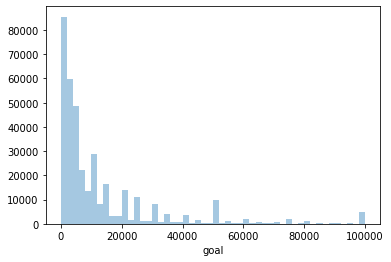

In [5]:
sns.distplot(a=df.goal, bins=50, kde=False, hist_kws={
    'range': (0, 100_000)
})

### Square root transformation

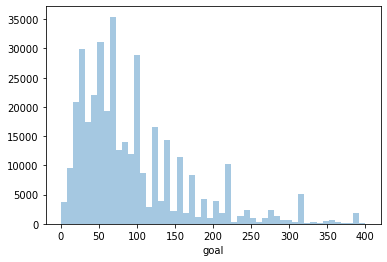

In [6]:
sns.distplot(a=np.sqrt(df.goal), label='sqrt(goal)', bins=50, kde=False, hist_kws={
    'range': (0, 400)
})

### Logarithm transformation

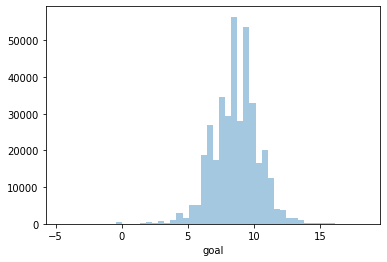

In [7]:
sns.distplot(a=np.log(df.goal), label="log(goal)", bins=50, kde=False)

## Scaling of features

In the california housing dataset, the median income in a block and the number of households features have very different scales and contain some very large outliers.

### Original data

In [8]:
df = get_housing_data()
df.head()

,median_income,number_households
0,8.3252,2.555556
1,8.3014,2.109842
2,7.2574,2.802260
3,5.6431,2.547945
4,3.8462,2.181467


In [9]:
df.describe()

,median_income,number_households
count,20640.000000,20640.000000
mean,3.870671,3.070655
std,1.899822,10.386050
min,0.499900,0.692308
25%,2.563400,2.429741
50%,3.534800,2.818116
75%,4.743250,3.282261
max,15.000100,1243.333333


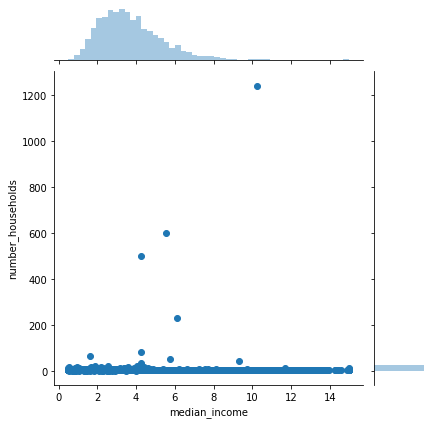

In [10]:
sns.jointplot('median_income', 'number_households', data=df, kind="scatter")

### StandardScaler

**Very sensitive to outliers.**

Removes the mean and scales the data to unit variance. 

Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

To be able to displayed the scaled values, we need to create a mask to hide outliers.

In [11]:
standard_scaler = StandardScaler()

scaled_data = standard_scaler.fit_transform(get_housing_data())

non_outliers_mask = get_non_outliers_mask(scaled_data)
print_min_max(scaled_data)

Min value for median_income: -1.7742994673175232
Max value for median_income: 5.858285811780286
Min value for number_housolds: -0.22899997443511985
Max value for number_housolds: 119.41910318829312


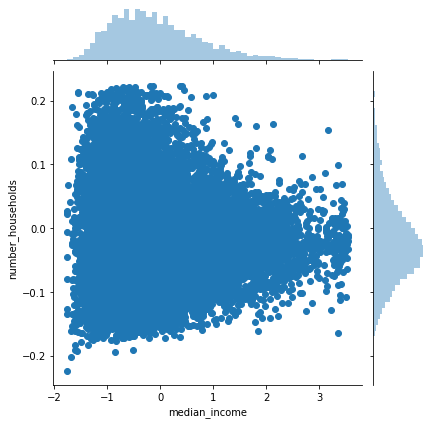

In [12]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data[non_outliers_mask], columns=["median_income", "number_households"]), kind="scatter")

### Normalization or MinMax Scaling

**Very sensitive to outliers**

Rescales all feature values to be in range \[0-1\].

To be able to displayed the scaled values, we need to create a mask to hide outliers.


In [13]:
minmax_scaler = MinMaxScaler()

scaled_data = minmax_scaler.fit_transform(get_housing_data())

non_outliers_mask = get_non_outliers_mask(scaled_data)
print_min_max(scaled_data)

Min value for median_income: 0.0
Max value for median_income: 1.0
Min value for number_housolds: 0.0
Max value for number_housolds: 0.9999999999999999


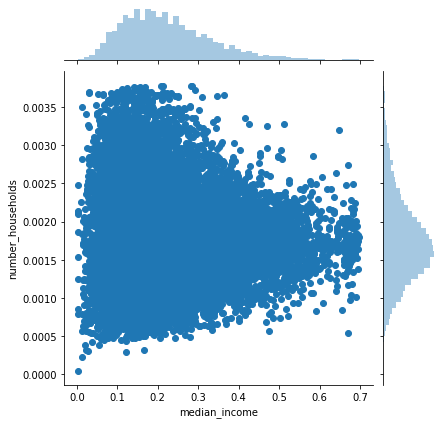

In [14]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data[non_outliers_mask], columns=["median_income", "number_households"]), kind="scatter")

### MaxAbsScaler

**Very sensitive to outliers**

Absolute values are mapped in the range \[0-1\].

On positive data, similar behaviour than MinMaxScaler.

In [15]:
maxabs_scaler = MaxAbsScaler()

scaled_data = maxabs_scaler.fit_transform(get_housing_data())

non_outliers_mask = get_non_outliers_mask(scaled_data)
print_min_max(scaled_data)

Min value for median_income: 0.03332644449037007
Max value for median_income: 1.0
Min value for number_housolds: 0.0005568158383171788
Max value for number_housolds: 1.0


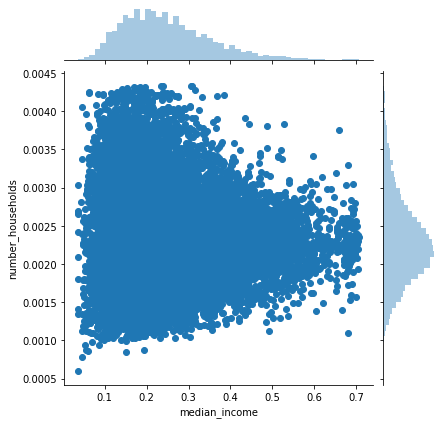

In [16]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data[non_outliers_mask], columns=["median_income", "number_households"]), kind="scatter")

### RobustScaler

centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers.

Adding or removing outliers in the training set will yield approximately the same transformation on held out data.

In [17]:
robust_scaler = RobustScaler(quantile_range=(25, 75))

scaled_data = robust_scaler.fit_transform(get_housing_data())
non_outliers_mask = get_non_outliers_mask(scaled_data)
print_min_max(scaled_data)

Min value for median_income: -1.392251760442232
Max value for median_income: 5.259673830768172
Min value for number_housolds: -2.4935585309601374
Max value for number_housolds: 1455.1160589513665


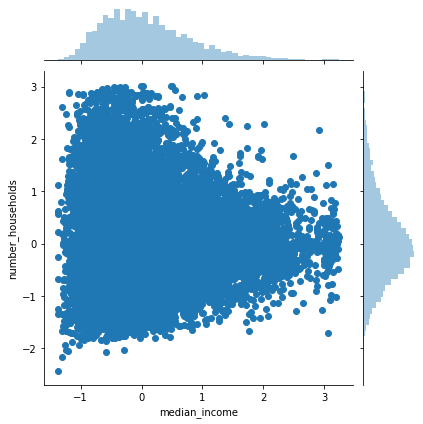

In [18]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data[non_outliers_mask], columns=["median_income", "number_households"]), kind="scatter")

### PowerTransformer

PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like. The power transform finds the optimal scaling factor to stabilize variance and mimimize skewness through maximum likelihood estimation. By default, PowerTransformer also applies zero-mean, unit variance normalization to the transformed output.



In [19]:
power_transformer = PowerTransformer(method='yeo-johnson')

scaled_data = power_transformer.fit_transform(get_housing_data())
print_min_max(scaled_data)

Min value for median_income: -3.4460847800757484
Max value for median_income: 3.146571469750347
Min value for number_housolds: -6.437977309304264
Max value for number_housolds: 5.969822749024247


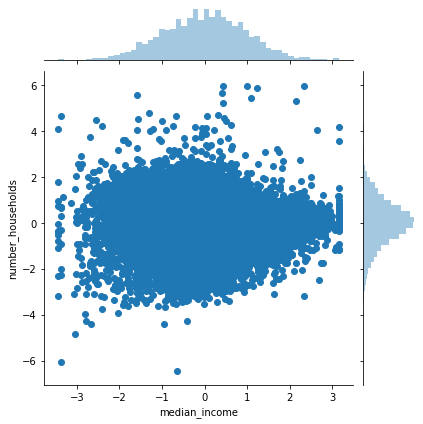

In [20]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data, columns=["median_income", "number_households"]), kind="scatter")

In [21]:
power_transformer = PowerTransformer(method='box-cox')

scaled_data = power_transformer.fit_transform(get_housing_data())
non_outliers_mask = get_non_outliers_mask(scaled_data)
print_min_max(scaled_data)

Min value for median_income: -3.802567796371907
Max value for median_income: 3.309825304683896
Min value for number_housolds: -7.7402419798729305
Max value for number_housolds: 7.758215989065241


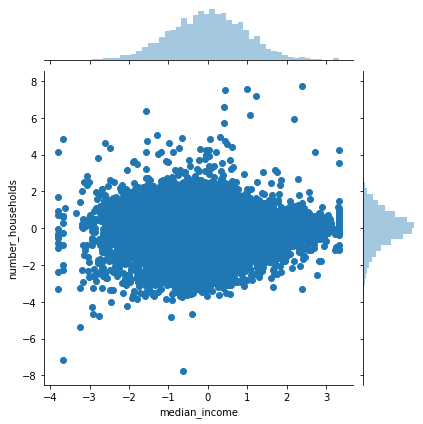

In [22]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data, columns=["median_income", "number_households"]), kind="scatter")

### QuantileTransformer (Gaussian output)

Can choose normal or uniform for the output distribution.

For the uniform, all the data will be mapped in the range \[0, 1\], even the outliers which cannot be distinguished anymore from the inliners.

In [23]:
quantile_transformer = QuantileTransformer(output_distribution="normal")

scaled_data = quantile_transformer.fit_transform(get_housing_data())
non_outliers_mask = get_non_outliers_mask(scaled_data)
print_min_max(scaled_data)

Min value for median_income: -5.199337582605575
Max value for median_income: 5.19933758270342
Min value for number_housolds: -5.199337582605575
Max value for number_housolds: 5.19933758270342


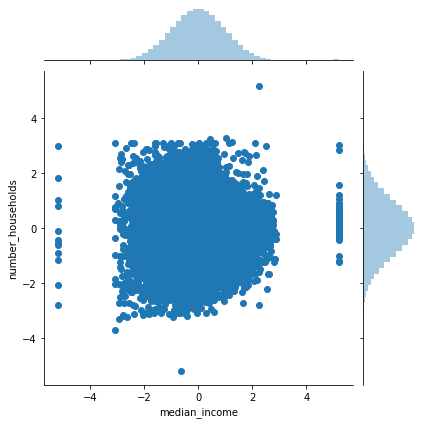

In [24]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data, columns=["median_income", "number_households"]), kind="scatter")

In [25]:
quantile_transformer = QuantileTransformer(output_distribution="uniform")

scaled_data = quantile_transformer.fit_transform(get_housing_data())
non_outliers_mask = get_non_outliers_mask(scaled_data)
print_min_max(scaled_data)

Min value for median_income: 0.0
Max value for median_income: 1.0
Min value for number_housolds: 0.0
Max value for number_housolds: 1.0


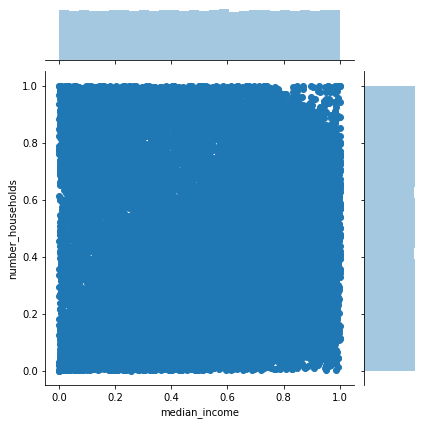

In [26]:
sns.jointplot('median_income', 'number_households', data=pd.DataFrame(scaled_data, columns=["median_income", "number_households"]), kind="scatter")

## Cyclical features handling

Hours of the day, days of the week, months in a year, and wind direction are all examples of features that are cyclical. The best way to engineer **cyclical features** is to represent these as (x, y) coordinates on a circle using sin and cos functions. For example, for hours variable, 0 (midnight) is on the right, the hours increase counterclockwise around the circle. In this way,
23:59 is very close to 00:090 as it should be.

If we do that for month (1-12), we usually shift from 1 to have 0-11 for convenience.



In [27]:
df = read_updated_data()

In [28]:
df = df.assign(
    launched_hour = df.launched.dt.hour,
    launched_day = df.launched.dt.day,
    launched_month = df.launched.dt.month,
    launched_year = df.launched.dt.year
)
df.head()

,ID,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,week_day,outcome,launched_hour,launched_day,launched_month,launched_year
0,1000002330,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,GB,0.0,0.0,1533.95,Tuesday,0,12,11,8,2015
1,1000003930,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,US,100.0,2421.0,30000.00,Saturday,0,4,2,9,2017
2,1000004038,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,220.0,220.0,45000.00,Saturday,0,0,12,1,2013
3,1000007540,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,1.0,1.0,5000.00,Saturday,0,3,17,3,2012
4,1000011046,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,14,US,1283.0,1283.0,19500.00,Saturday,0,8,4,7,2015


In [29]:
df['launched_hour_sin'] = np.sin(df.launched_hour * (2. * np.pi/24))
df['launched_hour_cos'] = np.cos(df.launched_hour * (2. * np.pi/24))

In [30]:
df['launched_month_sin'] = np.sin(df.launched_month * (2. * np.pi/12))
df['launched_month_cos'] = np.cos(df.launched_month * (2. * np.pi/12))

In [31]:
df.head()

,ID,category,main_category,currency,deadline,goal,launched,pledged,backers,country,...,week_day,outcome,launched_hour,launched_day,launched_month,launched_year,launched_hour_sin,launched_hour_cos,launched_month_sin,launched_month_cos
0,1000002330,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,GB,...,Tuesday,0,12,11,8,2015,1.224647e-16,-1.000000,-0.866025,-5.000000e-01
1,1000003930,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,US,...,Saturday,0,4,2,9,2017,8.660254e-01,0.500000,-1.000000,-1.836970e-16
2,1000004038,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,...,Saturday,0,0,12,1,2013,0.000000e+00,1.000000,0.500000,8.660254e-01
3,1000007540,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,...,Saturday,0,3,17,3,2012,7.071068e-01,0.707107,1.000000,6.123234e-17
4,1000011046,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,14,US,...,Saturday,0,8,4,7,2015,8.660254e-01,-0.500000,-0.500000,-8.660254e-01
